## Классификация изображений из датасета Intel Image Classification с помощью CNN (Keras)

## Описание задачи:   
Данные - это изображения природных сцен всего мира.

Тут содержится около 25 тыс. изображений размером 150x150, распределенных по 6 категориям:  
> buildings (здания) -> 0  
forest (лес) -> 1  
glacier (ледник) -> 2  
mountain (гора) -> 3  
sea (море) -> 4  
> street (улица) -> 5  

Данные для обучения, тестирования и прогноза разделены на zip-файлы. При этом в Train 14 034 изображений, в Test - 3 000, а в Prediction - 7 000.

Необходимо построить модель, которая сможет классифицировать эти изображения с точностью (Accuracy) не менее 85%.

## Подключение библиотек

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

import os
import cv2
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from random import randint

import tensorflow as tf
import tensorflow.keras.optimizers as Optimizer

import gc

In [ ]:
from keras.applications.vgg16 import VGG16

## Подготовительный этап
Определим основные переменные и подготовим необходимые функции

In [ ]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {'mountain' : 0, 'street' : 1, 'glacier': 2, 'buildings' : 3, 'sea' : 4, 'forest' : 5}

Прежде всего напишем функцию load_data, которая будет загружать изображения и метки из папки. Конечно можно воспользоваться встроенным методом, но для наглядности сделаем свой

In [ ]:
def load_data(train_path, test_path):
    
    datasets = [train_path, test_path]
    output = []
    
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        for folder in os.listdir(dataset):
            label = class_names_label[folder]

            for file in tqdm(os.listdir(f'{dataset}/{folder}')):
              
                image = cv2.imread(f'{dataset}/{folder}/{file}')
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, (150, 150)) 
                
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

И функцию для визуализации полученных результатов

In [ ]:
def plotter(history):
    #summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

## Загрузка данных

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
! kaggle datasets download -d puneet6060/intel-image-classification --unzip

 96% 331M/346M [00:02<00:00, 164MB/s]
100% 346M/346M [00:02<00:00, 167MB/s]


Загрузим изображения и метки из папок:

In [ ]:
(train_images, train_labels), (test_images, test_labels) = load_data('/content/seg_train/seg_train', '/content/seg_test/seg_test')

Loading /content/seg_train/seg_train


100%|██████████| 2271/2271 [00:01<00:00, 1388.46it/s]


Loading /content/seg_test/seg_test


100%|██████████| 474/474 [00:00<00:00, 1326.87it/s]


Из обучающего сета выделим валидационный набор

In [ ]:
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, shuffle=True, test_size=0.2, random_state=21)

## Нормализация (масштабирование) данных

Так как функция imread из библиотеки OpenCV возвращает 3D (для цветного изображения) массив NumPy в котором каждая компонента представлена в диапазоне [0,255], а алгоритмы машинного обучения лучше работают с небольшими числами, приведем все значения к диапазону [0, 1]:

In [ ]:
train_images = train_images / 255.0
val_images = val_images / 255.0
test_images = test_images / 255.0

## Анализ имеющегося набора данных

1. Посмотрим на имеющиеся изображения.  
Для этого отобразим первые 25 изображений из обучающего набора:

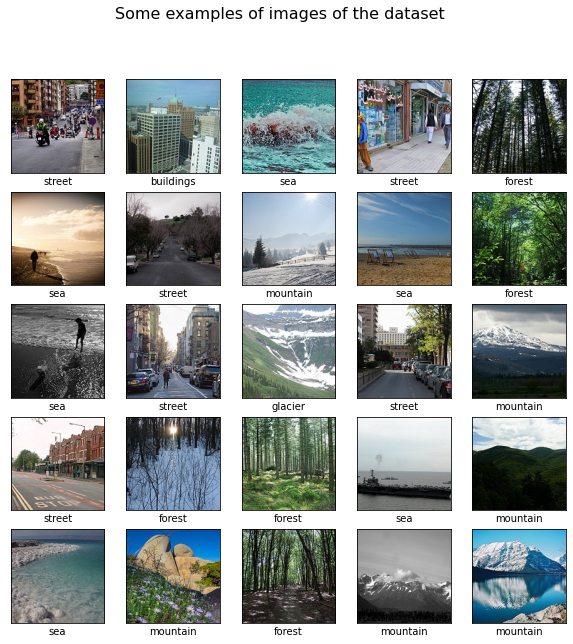

In [ ]:
fig = plt.figure(figsize=(10,10))
fig.suptitle("Some examples of images of the dataset", fontsize=16)
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

2. Перепроверим получившееся количество изображений в Train, Validation и Test:

In [ ]:
print("Number of training examples: {}".format(train_labels.shape[0]))
print("Number of validation examples: {}".format(val_labels.shape[0]))
print("Number of testing examples: {}".format(test_labels.shape[0]))

Number of training examples: 11227
Number of validation examples: 2807
Number of testing examples: 3000


3. Какова доля изображений в каждой наблюдаемой категории:

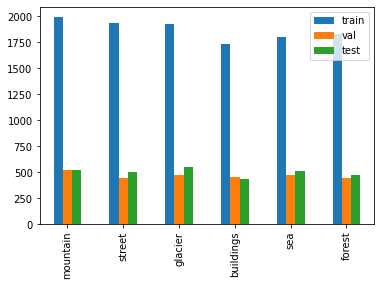

In [ ]:
_, train_counts = np.unique(train_labels, return_counts=True)
_, val_counts = np.unique(val_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
              'val': val_counts,
              'test': test_counts},
             index=class_names
            ).plot.bar()
plt.show()

Изображения отображаются корректно, кол-во изображений не изменилось, распределение изображений между классами довольно равномерное (как в train, так и в validation и test)

## Аугментация данных

Для аугментации изображений буду использовать библиотеку Albumentations

In [ ]:
import albumentations as A

### Проверка 

Рассмотрим возможность применения *простых* преобразований для имеющихся изображений. Для этого возьмем случайное изображение из обучающей выборки:

In [ ]:
index = np.random.randint(train_images.shape[0])
image = train_images[index]

для оценки возможности использования напишем функцию для отображения оригинального и измененного изображения 

In [ ]:
def visualize(image, augmented_image):
    plt.figure(figsize=(9,9))
    plt.axis('off')
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Original')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(augmented_image)
    plt.title('Augmented')
    plt.axis('off')

1. Зеркальное отображение (горизонтальное)

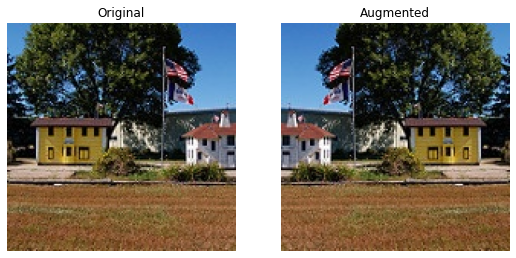

In [ ]:
transform = A.HorizontalFlip(p=1)
augmented_image = transform(image=image)['image']
visualize(image, augmented_image)

2. Зеркальное отображение (вертикальное)

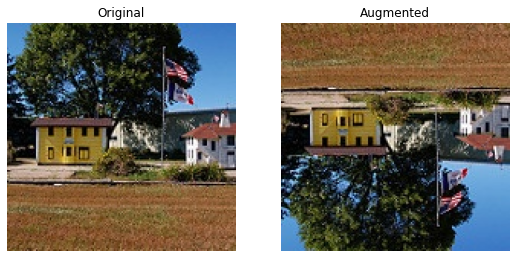

In [ ]:
transform = A.VerticalFlip(p=1)
augmented_image = transform(image=image)['image']
visualize(image, augmented_image)

3. Поворот

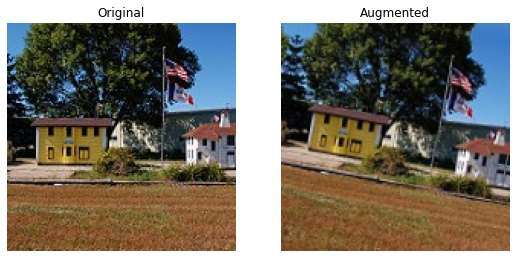

In [ ]:
transform = A.Rotate(limit=20, p=1)
augmented_image = transform(image=image)['image']
visualize(image, augmented_image)

4. Изменение яркости и контрасности

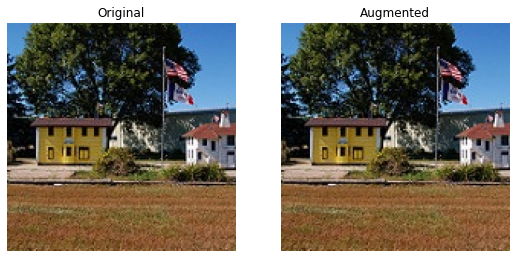

In [ ]:
transform = A.RandomBrightnessContrast(brightness_limit=0.5, contrast_limit=0.5, p=0.9)
augmented_image = transform(image=image)['image']
visualize(image, augmented_image)

5. Масштабирование (обрезка) 

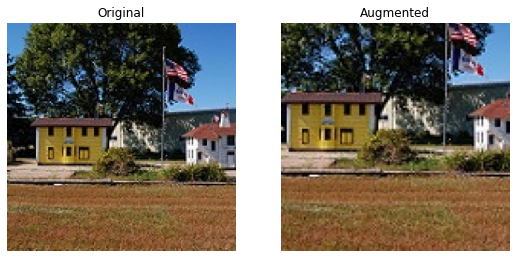

In [ ]:
transform = A.RandomCrop(120,120) 
augmented_image = transform(image=image)['image']
visualize(image, augmented_image)

6. Изменение гаммы

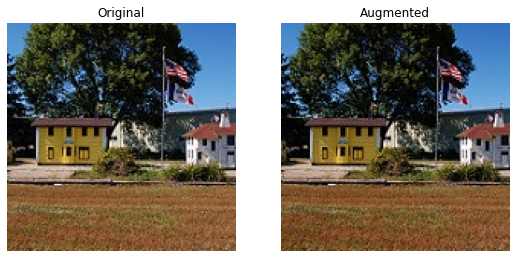

In [ ]:
transform = A.RandomGamma(gamma_limit=(100, 120), p=1) 
augmented_image = transform(image=image)['image']
visualize(image, augmented_image)

7. Изменение насыщенности оттенков

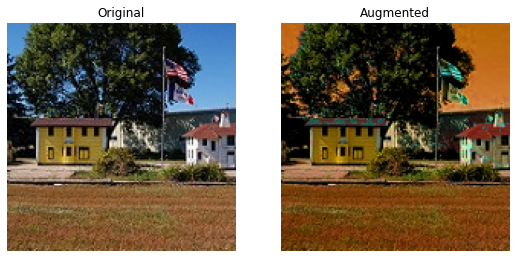

In [ ]:
transform = A.HueSaturationValue(hue_shift_limit=1, sat_shift_limit=1, val_shift_limit=1, p=0.9) 
augmented_image = transform(image=image)['image']
visualize(image, augmented_image)

8. Цветовой сдвиг

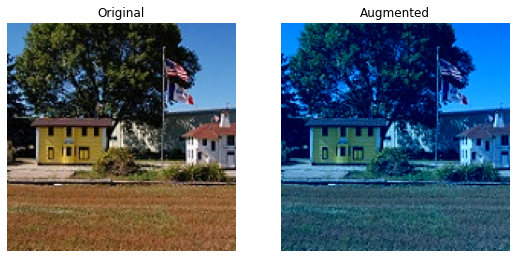

In [ ]:
transform = A.RGBShift(r_shift_limit=0.5, g_shift_limit=0.5, b_shift_limit=0.5, always_apply=False, p=1)
augmented_image = transform(image=image)['image']
visualize(image, augmented_image)

Проверив внесенные изменения на группе случайных картинок получаем следующие выводы:
- горизонтальное отображение никак не исказит изображения, при этом вертикальное для наших данных не подходит;
- поворот изображений может быть использован при условии выбора незначительного угла повората, так как его дальнейшее увеличение может привести к искажению некоторых групп изображений;
- изменение яркости, контрасности и гаммы также может быть использовано в разумных пределах;
- масштабирование следует выполнять очень аккуратно, так как некоторые трудноразличимые группы (например здания/улицы) могут стать ещё более трудноразделимыми, либо вовсе будут вводить модель в заблуждение;
- от изменения оттенков и цветов откажусь, чтобы не усугубить ситуацию с трудноразделимыми группами (например ледники/горы и ледники/море)

### Применение

Для этого будем использовать свой генератор данных

In [ ]:
from tensorflow.keras.utils import Sequence

class DataLoader(Sequence):
    def __init__(self, x, y, batch_size, augmentations):
        self.x, self.y = x, y
        self.batch_size = batch_size
        self.augment = augmentations

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        return np.stack([self.augment(image=x)['image'] for x in batch_x], axis=0), np.array(batch_y)

С применением следующих аугментаций для обучающего сета (к валидационному изменения не применяем):

In [ ]:
transform_train = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=20, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.RandomCrop(150,150, p=0.5),
    A.RandomGamma(gamma_limit=(80, 120), p=0.5)
])

transform_val = A.Compose([])

In [ ]:
train_gen = DataLoader(train_images, train_labels, batch_size=64, augmentations=transform_train)

In [ ]:
val_gen = DataLoader(val_images, val_labels, batch_size=64, augmentations=transform_val)

## Создание простой базовой модели

Имеем задачу классификации изображений.   
В качестве базовой модели будем использовать сверточную нейросеть.

Модель состоит из 2 блоков свёртки после каждого из которых следует блок со слоем подвыборки (Pooling-слой для уменьшения изображения). Далее у нас идёт полносвязный слой с 128 нейронами и функцией активации relu. Модель выдаст распределение вероятностей по 6 классам используя softmax

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters = 32, kernel_size = (3, 3),  activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(6, activation="softmax")
])

In [ ]:
model.compile(optimizer=Optimizer.Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(x = train_images, y =  train_labels, batch_size=64, epochs=20, validation_data = (val_images, val_labels))

Epoch 1/20
176/176 [==============================] - 25s 85ms/step - loss: 1.0727 - accuracy: 0.5934 - val_loss: 0.9744 - val_accuracy: 0.6135
Epoch 2/20
176/176 [==============================] - 14s 77ms/step - loss: 0.8079 - accuracy: 0.7090 - val_loss: 0.8486 - val_accuracy: 0.6819
Epoch 3/20
176/176 [==============================] - 13s 76ms/step - loss: 0.6742 - accuracy: 0.7659 - val_loss: 0.7084 - val_accuracy: 0.7471
Epoch 4/20
176/176 [==============================] - 13s 77ms/step - loss: 0.5893 - accuracy: 0.7998 - val_loss: 0.6822 - val_accuracy: 0.7513
Epoch 5/20
176/176 [==============================] - 14s 78ms/step - loss: 0.5116 - accuracy: 0.8325 - val_loss: 0.6516 - val_accuracy: 0.7638
Epoch 6/20
176/176 [==============================] - 14s 77ms/step - loss: 0.4689 - accuracy: 0.8424 - val_loss: 0.6847 - val_accuracy: 0.7538
Epoch 7/20
176/176 [==============================] - 14s 77ms/step - loss: 0.4116 - accuracy: 0.8692 - val_loss: 0.6024 - val_accuracy:

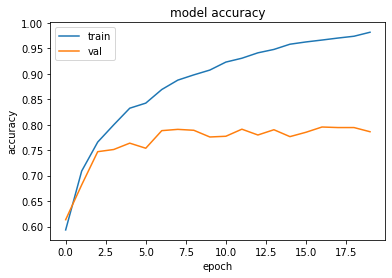

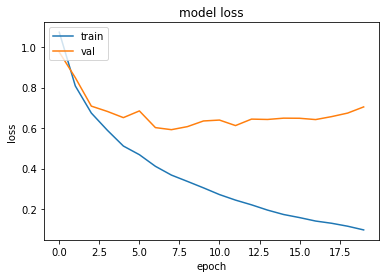

In [ ]:
plotter(history)

Проведя эксперименты с изменением количества эпох приходим к выводу, что их увеличение не приносит какого-либо значимого результата.   
Также на графиках видно, что точность на тренировочном и валидационном наборах данных различаются на достаточно большое значение, при этом точность на тренировочных данных продолжает расти и стремится к 100%, а на валидационных остается примерно на одном и том же уровне. Видим явные признаки переобучения


Оценим производительность модели на тестовых данных

In [ ]:
test_loss = model.evaluate(test_images, test_labels)

94/94 [==============================] - 2s 18ms/step - loss: 0.7035 - accuracy: 0.7763


Точность нашей базовой модели достигла всего лишь ~77% как на валидационном так и на тестовом наборе данных

In [ ]:
gc.collect()

7620

### Анализ работы базовой модели

Проанализируем на каких изображениях у классификатора проблемы:

In [ ]:
predictions = model.predict(test_images)
pred_labels = np.argmax(predictions, axis = 1)

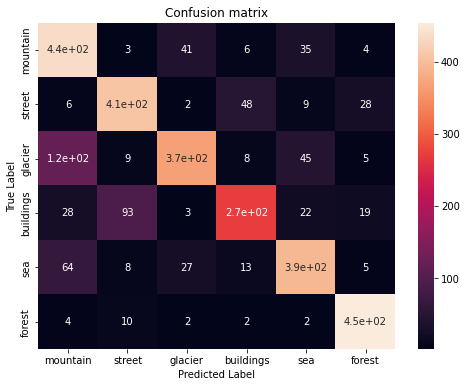

In [ ]:
CM = confusion_matrix(test_labels, pred_labels)
plt.subplots(figsize=(8, 6))
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.set_title('Confusion matrix')

plt.show()

### Выводы

У классификатора проблемы с разделением:
1. Гор от Моря.
1. Ледника от Гор.
2. Улиц от Зданий.

Если более детально рассмотреть входные данные, то увидим, что на многих изображениях гор присутствуют водоемы, а также на многих изображениях гор присутствуют ледники (и наоборот). Проблема с раздедением улиц от зданий также понятна - ведь на улице есть здания.

Данные ошибки вполне могут быть допущены и людьми.  
Предположим что более сложная модель позволит выделять более сложные признаки, которые в свою очередь позволят разделить данные классы друг от друга. 

## Базовая модель + аугментация данных

Но сначало попробую улучшить работу базовой модели по средствам увеличения количества тренировочных данных с помощью аугментации. 

Это позволит нам оценить эффект от "раздутия" входных данных, для решения проблемы переобучения.

Все параметры базовой модели оставим без изменений.

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters = 32, kernel_size = (3, 3),  activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(6, activation="softmax")
])

In [ ]:
model.compile(optimizer=Optimizer.Adam(learning_rate=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

Данная модель была опробована на разном количестве эпох и опытным путем было определено, что после 30 эпох происходит значительное расхождение в точности между обучающей и валидационной выборкой. Поэтому на данном количестве и остановимся.

In [ ]:
history = model.fit(train_gen, batch_size=64, epochs=30, validation_data=val_gen)

Epoch 1/30
176/176 [==============================] - 23s 126ms/step - loss: 1.1286 - accuracy: 0.5740 - val_loss: 0.9680 - val_accuracy: 0.6409
Epoch 2/30
176/176 [==============================] - 22s 123ms/step - loss: 0.9045 - accuracy: 0.6695 - val_loss: 0.8196 - val_accuracy: 0.7032
Epoch 3/30
176/176 [==============================] - 22s 123ms/step - loss: 0.8047 - accuracy: 0.7126 - val_loss: 0.8220 - val_accuracy: 0.7104
Epoch 4/30
176/176 [==============================] - 22s 124ms/step - loss: 0.7385 - accuracy: 0.7372 - val_loss: 0.7960 - val_accuracy: 0.7082
Epoch 5/30
176/176 [==============================] - 22s 124ms/step - loss: 0.6954 - accuracy: 0.7544 - val_loss: 0.6890 - val_accuracy: 0.7549
Epoch 6/30
176/176 [==============================] - 22s 122ms/step - loss: 0.6607 - accuracy: 0.7689 - val_loss: 0.6452 - val_accuracy: 0.7727
Epoch 7/30
176/176 [==============================] - 22s 124ms/step - loss: 0.6171 - accuracy: 0.7857 - val_loss: 0.6537 - val_ac

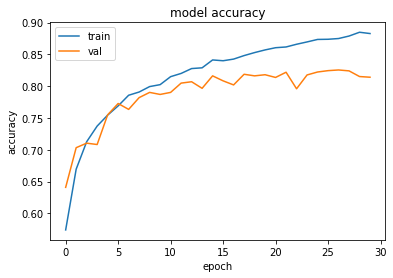

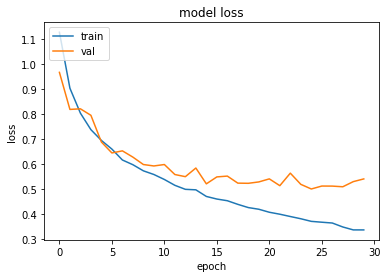

In [ ]:
plotter(history)

На данных графиках можем наблюдать, что применение аугментаций позволили преодалеть порог по точности достигнутый на предыдущем шаге и повысить уровень качества.

И хотя, примерно после 15 эпохи точность на тренировочных данных начинает "отставать" от обучающих, прогресс всё равно имеется вплоть до 30 эпохи. Соответственно применение аугментаций позволили увеличить количество эпох обучения до наступления переобучения.

Оценим производительность модели на тестовых данных

In [ ]:
test_loss_baseAug = model.evaluate(test_images, test_labels)

94/94 [==============================] - 2s 17ms/step - loss: 0.5316 - accuracy: 0.8200


Точность базовой модели с применением аугментации на тестовом наборе данных достигла ~82%.  
Прирост точности от применение аугментаций составил 5%

In [ ]:
gc.collect()

13788

## Усовершенствованная модель

Попробуем незначительно усложнить базовую модель для возможности выделять более сложные признаки с целью лучшего определения трудноразделимых признаков

Усовершенствованная модель состоит из 3 блоков свёртки после каждого из которых следует блок со слоем подвыборки (Pooling-слой для уменьшения изображения). Далее у нас идёт полносвязный слой на 256 нейронов с применением регуляризации (Drop out) и функцией активации relu. Модель выдаст распределение вероятностей по 6 классам используя softmax

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters = 32, kernel_size = (5, 5),  activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(3,3),

    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(6, activation="softmax")
])

In [ ]:
model.compile(optimizer=Optimizer.Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Данная модель также была опробована на разном количестве эпох и дальнейшее увеличение (более 25) не имеет смысла из-за переобучения

In [ ]:
history = model.fit(x = train_images, y =  train_labels, batch_size=64, epochs=25, validation_data = (val_images, val_labels))

Epoch 1/25
176/176 [==============================] - 13s 72ms/step - loss: 1.2699 - accuracy: 0.5024 - val_loss: 1.0540 - val_accuracy: 0.5661
Epoch 2/25
176/176 [==============================] - 12s 67ms/step - loss: 0.9905 - accuracy: 0.6209 - val_loss: 0.9020 - val_accuracy: 0.6641
Epoch 3/25
176/176 [==============================] - 12s 68ms/step - loss: 0.8601 - accuracy: 0.6862 - val_loss: 0.7929 - val_accuracy: 0.7007
Epoch 4/25
176/176 [==============================] - 12s 67ms/step - loss: 0.7940 - accuracy: 0.7092 - val_loss: 0.7551 - val_accuracy: 0.7175
Epoch 5/25
176/176 [==============================] - 12s 68ms/step - loss: 0.7373 - accuracy: 0.7312 - val_loss: 0.6923 - val_accuracy: 0.7456
Epoch 6/25
176/176 [==============================] - 12s 68ms/step - loss: 0.6834 - accuracy: 0.7520 - val_loss: 0.6575 - val_accuracy: 0.7581
Epoch 7/25
176/176 [==============================] - 12s 67ms/step - loss: 0.6724 - accuracy: 0.7592 - val_loss: 0.6818 - val_accuracy:

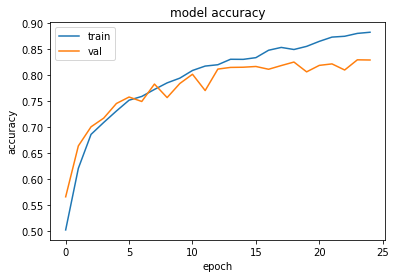

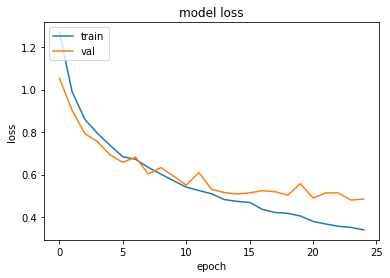

In [ ]:
plotter(history)

На данных графиках можем наблюдать, что применение усложнение базовой модели также позволило преодалеть порог по точности и повысить уровень качества.

Оценим производительность модели на тестовых данных

In [ ]:
test_loss_improved = model.evaluate(test_images, test_labels)

94/94 [==============================] - 2s 21ms/step - loss: 0.4722 - accuracy: 0.8373


Точность усовершенствованной модели на валидационном и тестовом наборе данных достигла ~ 83%, то есть данная модель имеет показатели, соизмеримые показателям базовой модели с использованием аугментаций.

In [ ]:
gc.collect()

847

## Усовершенствованная модель + аугментация данных

Попробую совместить решения, используемые на двух предыдущих шагах и повысить точность усовершенствованной модели с помощью аугментации.

Все параметры модели также оставим без изменений.

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters = 32, kernel_size = (5, 5),  activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(3,3),

    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(6, activation="softmax")
])

In [ ]:
model.compile(optimizer=Optimizer.Adam(learning_rate=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

Разнообразие входных данных (за счет аугментации) и более сложная структура модели позволяют увеличивать количество эпох обучения вплоть до 50 без признаков переобучения. при этом дальнейшее увелтчение смысла не имеет по причине отсутсвия прогресса.

In [ ]:
history = model.fit(train_gen, batch_size=64, epochs=50, validation_data=val_gen)

Epoch 1/50
176/176 [==============================] - 24s 131ms/step - loss: 1.2828 - accuracy: 0.4901 - val_loss: 1.0099 - val_accuracy: 0.6063
Epoch 2/50
176/176 [==============================] - 23s 129ms/step - loss: 1.0079 - accuracy: 0.6201 - val_loss: 0.9170 - val_accuracy: 0.6491
Epoch 3/50
176/176 [==============================] - 22s 128ms/step - loss: 0.9150 - accuracy: 0.6540 - val_loss: 0.7955 - val_accuracy: 0.7093
Epoch 4/50
176/176 [==============================] - 22s 127ms/step - loss: 0.8632 - accuracy: 0.6835 - val_loss: 0.7410 - val_accuracy: 0.7289
Epoch 5/50
176/176 [==============================] - 22s 127ms/step - loss: 0.8029 - accuracy: 0.7046 - val_loss: 0.7132 - val_accuracy: 0.7456
Epoch 6/50
176/176 [==============================] - 22s 126ms/step - loss: 0.7714 - accuracy: 0.7160 - val_loss: 0.7002 - val_accuracy: 0.7435
Epoch 7/50
176/176 [==============================] - 23s 128ms/step - loss: 0.7276 - accuracy: 0.7388 - val_loss: 0.6755 - val_ac

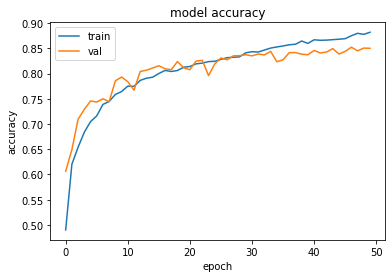

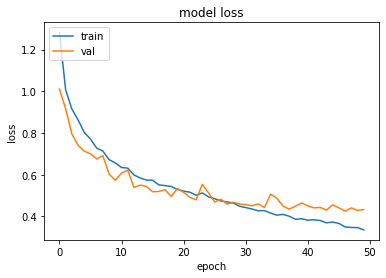

In [ ]:
plotter(history)

Оценим производительность модели на тестовых данных

In [ ]:
test_loss_improvedAug = model.evaluate(test_images, test_labels)

94/94 [==============================] - 2s 22ms/step - loss: 0.4126 - accuracy: 0.8613


Точность усовершенствованной модели с применением аугментаций на тестовом наборе данных достигла 86%.

In [ ]:
gc.collect()

442

In [ ]:
model.save('ImprovedAug.model_50epochs')

INFO:tensorflow:Assets written to: ImprovedAug.model_50epochs/assets


## Построение модели на основе VGG-16 (ImageNet)

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

### Выделение признаков с помощью VGG-16

Для проведения анализа, выделим признаки из обучающего сета с помощью VGG-16 и визуализируем их.

In [ ]:
model = VGG16(weights='imagenet', include_top=False)

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
train_features = model.predict(train_images)

Визуализизация признаков по средствам PCA

In [ ]:
n_train, x, y, z = train_features.shape
numFeatures = x * y * z

In [ ]:
from sklearn import decomposition

pca = decomposition.PCA(n_components = 2)

X = train_features.reshape((n_train, x*y*z))
pca.fit(X)

C = pca.transform(X)
C1 = C[:,0]
C2 = C[:,1]

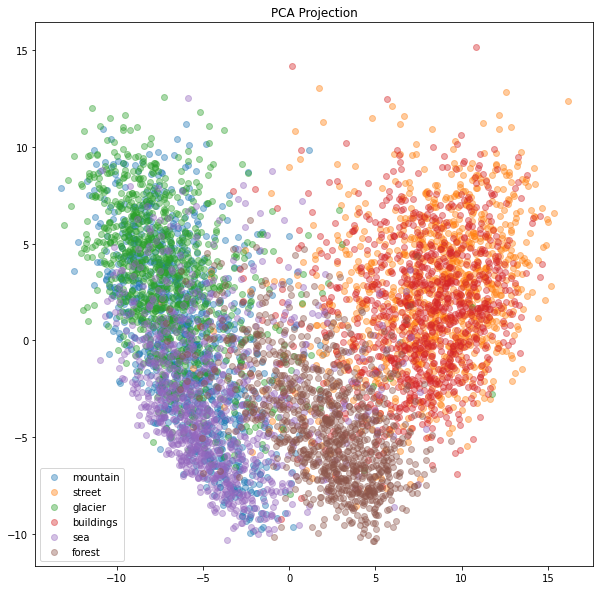

In [ ]:
plt.subplots(figsize=(10,10))

for i, class_name in enumerate(class_names):
    plt.scatter(C1[train_labels == i][:1000], C2[train_labels == i][:1000], label = class_name, alpha=0.4)
plt.legend()
plt.title("PCA Projection")
plt.show()

После анализа данной визуализации приходим к тем же выводам, к которым мы пришли при анализе работы базовой модели:
- точки ледников и гор очень близки друг к другу;
- практически нет различий между морем и горами;
- практически нет различий между зданиями и улицей.

### Построение модели на основе VGG-16 (ImageNet)

#### Использование архитектуры сети VGG-16 с исходными (замороженными) весами и дообученным классификатором.

In [ ]:
vgg16_model = VGG16(weights='imagenet', input_shape = (150, 150, 3), include_top=False)
vgg16_model.trainable = False

In [ ]:
model = tf.keras.Sequential([                         
    vgg16_model,                         
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(6, activation='softmax')
])

In [ ]:
model.compile(optimizer=Optimizer.Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(x = train_images, y =  train_labels, batch_size=64, epochs=10, validation_data = (val_images, val_labels))

Epoch 1/10
176/176 [==============================] - 82s 369ms/step - loss: 0.7551 - accuracy: 0.7242 - val_loss: 0.4642 - val_accuracy: 0.8361
Epoch 2/10
176/176 [==============================] - 52s 297ms/step - loss: 0.4696 - accuracy: 0.8355 - val_loss: 0.4113 - val_accuracy: 0.8514
Epoch 3/10
176/176 [==============================] - 52s 297ms/step - loss: 0.4042 - accuracy: 0.8571 - val_loss: 0.3872 - val_accuracy: 0.8571
Epoch 4/10
176/176 [==============================] - 52s 296ms/step - loss: 0.3594 - accuracy: 0.8727 - val_loss: 0.3764 - val_accuracy: 0.8664
Epoch 5/10
176/176 [==============================] - 52s 297ms/step - loss: 0.3272 - accuracy: 0.8847 - val_loss: 0.3582 - val_accuracy: 0.8707
Epoch 6/10
176/176 [==============================] - 52s 296ms/step - loss: 0.3076 - accuracy: 0.8904 - val_loss: 0.3498 - val_accuracy: 0.8717
Epoch 7/10
176/176 [==============================] - 52s 297ms/step - loss: 0.2869 - accuracy: 0.8994 - val_loss: 0.3514 - val_ac

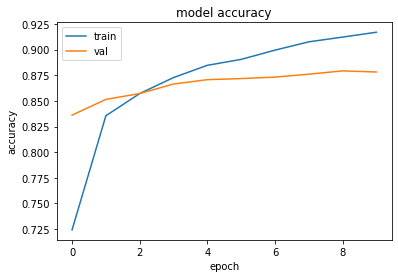

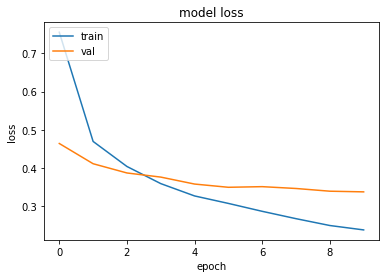

In [ ]:
plotter(history)

И видим что классификатор практически необучился, но имеет достаточно неплохие показатели с самого начала обучения. Изменение параметров модели существенных результатов не дали.

In [ ]:
test_loss_vgg = model.evaluate(test_images, test_labels)

94/94 [==============================] - 21s 172ms/step - loss: 0.3105 - accuracy: 0.8820


Тем не менее данная модель имеет ~88% точности на валидационном и тестовом наборе данных, что превосходит показатели сети с прошлого шага

In [ ]:
gc.collect()

11330

#### Переобученная сеть VGG-16 с измененным классификатором.

In [ ]:
vgg16_model = VGG16(weights='imagenet', input_shape = (150, 150, 3), include_top=False)

In [ ]:
model = tf.keras.Sequential([                         
    vgg16_model,                         
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(6, activation='softmax')
])

In [ ]:
model.compile(optimizer=Optimizer.Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(x = train_images, y = train_labels, batch_size=64, epochs=20, validation_data = (val_images, val_labels))

Epoch 1/20
176/176 [==============================] - 143s 804ms/step - loss: 1.3455 - accuracy: 0.4241 - val_loss: 0.7904 - val_accuracy: 0.7057
Epoch 2/20
176/176 [==============================] - 141s 803ms/step - loss: 0.7228 - accuracy: 0.7412 - val_loss: 0.6389 - val_accuracy: 0.7702
Epoch 3/20
176/176 [==============================] - 141s 803ms/step - loss: 0.5543 - accuracy: 0.8112 - val_loss: 0.4509 - val_accuracy: 0.8479
Epoch 4/20
176/176 [==============================] - 141s 803ms/step - loss: 0.4550 - accuracy: 0.8461 - val_loss: 0.4279 - val_accuracy: 0.8493
Epoch 5/20
176/176 [==============================] - 141s 802ms/step - loss: 0.3925 - accuracy: 0.8686 - val_loss: 0.4285 - val_accuracy: 0.8643
Epoch 6/20
176/176 [==============================] - 141s 802ms/step - loss: 0.3674 - accuracy: 0.8772 - val_loss: 0.4400 - val_accuracy: 0.8525
Epoch 7/20
176/176 [==============================] - 141s 803ms/step - loss: 0.3331 - accuracy: 0.8889 - val_loss: 0.3804 -

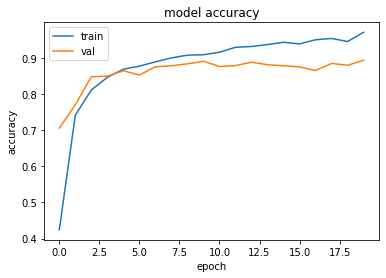

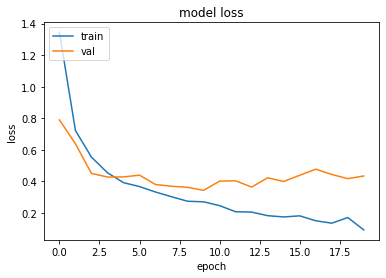

In [ ]:
plotter(history)

In [ ]:
test_loss_vggTrain = model.evaluate(test_images, test_labels)

94/94 [==============================] - 12s 132ms/step - loss: 0.4223 - accuracy: 0.8947


Модель значительно лучше обучается, но при этом показатели точности практически не изменились и достигли ~89% на валидационном и тестовом наборе данных

Увеличение числа эпох не имеет смысла, начинает рости значение функции ошибки, модель переобучается.

## Общие выводы

Посмотрим на результаты всех используемых моделей

In [ ]:
df = pd.DataFrame([['Простая базовая ', test_loss[0], test_loss[1]],
                   ['Базовая c аугментацией данных', test_loss_baseAug[0], test_loss_baseAug[1]],
                   ['Усовершенствованная', test_loss_improved[0], test_loss_improved[1]],
                   ['Усовершенствованная c аугментацией данных', test_loss_improvedAug[0], test_loss_improvedAug[1]],
                   ['На основе VGG-16 с исходными весами', test_loss_vgg[0], test_loss_vgg[1]]],
                   ['Переобученная VGG-16', test_loss_vggTrain[0], test_loss_vggTrain[1]]],
columns=['Наименование модели','loss', 'accuracy'])

In [ ]:
df

,Наименование модели,loss,accuracy
0,Простая базовая,0.703500,0.776300
1,Базовая c аугментацией данных,0.531600,0.820000
2,Усовершенствованная,0.472200,0.837300
3,Усовершенствованная c аугментацией данных,0.412600,0.861300
4,На основе VGG-16 с исходными весами,0.310500,0.882000
5,Переобученная VGG-16,0.422304,0.894667


Подведем итоги:   
Лучший точность показала сеть построенная на основе VGG-16 (~ 90%) с приемлимым значением функции потерь (~ 0.42).  
При этом таже сеть с исходными весами и дообученным классификатором показал точность чуть хуже (~ 88%), но значение функции потерь при этом даже лучше (~ 0.31)

Высокий результат вполне объясним, ведь при должном подходе VGG-16 достигает точности 92.7% в задачах распознавания объектов на изображении.   
Вместе с этим из-за глубины и количества полносвязных узлов сама архитектура сети весит достаточно много, а её тонкая настройка требует достаточное количество ресурсов и времени.

Принимая во внимание данный факт, для решения данной задачи я остановлюсь на усовершенствованной базовой модели c выполнением аугментации данных, так как её точность незначительно ниже (~ 86%, что удовоетворяет условию), при значении функции потерь ~ 0.41